# Multiclass classification
**Before this notebook, you should look at [Pandas_for_ML_data_management.ipynb](Pandas_for_ML_data_management.ipynb).**

## The machine learning iterative loop

![Iterative loop](../images/ML_loop.png)

## The lithology prediction task

<img src="../images/machine_learning_primer.png"></img>

## Load the data

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('https://geocomp.s3.amazonaws.com/data/Panoma_training_data.csv')
df.head()

,Well Name,Formation,Depth,GR,DeltaPHI,PHIND,ILD,PE,Marine,RelPos,Facies,ILD_log10,Lithofacies,RHOB,Mineralogy,Lithology
0,SHRIMPLIN,A1 SH,2793.0,77.45,9.9,11.915,21.281390,4.6,0,1.000,3,1.328,f_siltstone,2393.499945,siliciclastic,siltstone
1,SHRIMPLIN,A1 SH,2793.5,78.26,14.2,12.565,20.989399,4.1,0,0.979,3,1.322,f_siltstone,2416.119814,siliciclastic,siltstone
2,SHRIMPLIN,A1 SH,2794.0,79.05,14.8,13.050,20.701413,3.6,0,0.957,3,1.316,f_siltstone,2404.576056,siliciclastic,siltstone
3,SHRIMPLIN,A1 SH,2794.5,86.10,13.9,13.115,20.417379,3.5,0,0.936,3,1.310,f_siltstone,2393.249071,siliciclastic,siltstone
4,SHRIMPLIN,A1 SH,2795.0,74.58,13.5,13.300,19.678863,3.4,0,0.915,3,1.294,f_siltstone,2382.602601,siliciclastic,siltstone


# Intro to classification
A binary classification task with 2 features

In [3]:
chosen_well = 'NEWBY'
features = ['RHOB', 'GR']
X = df.loc[df['Well Name'] == chosen_well, features].values
y = df.loc[df['Well Name'] == chosen_well, 'Mineralogy'].values

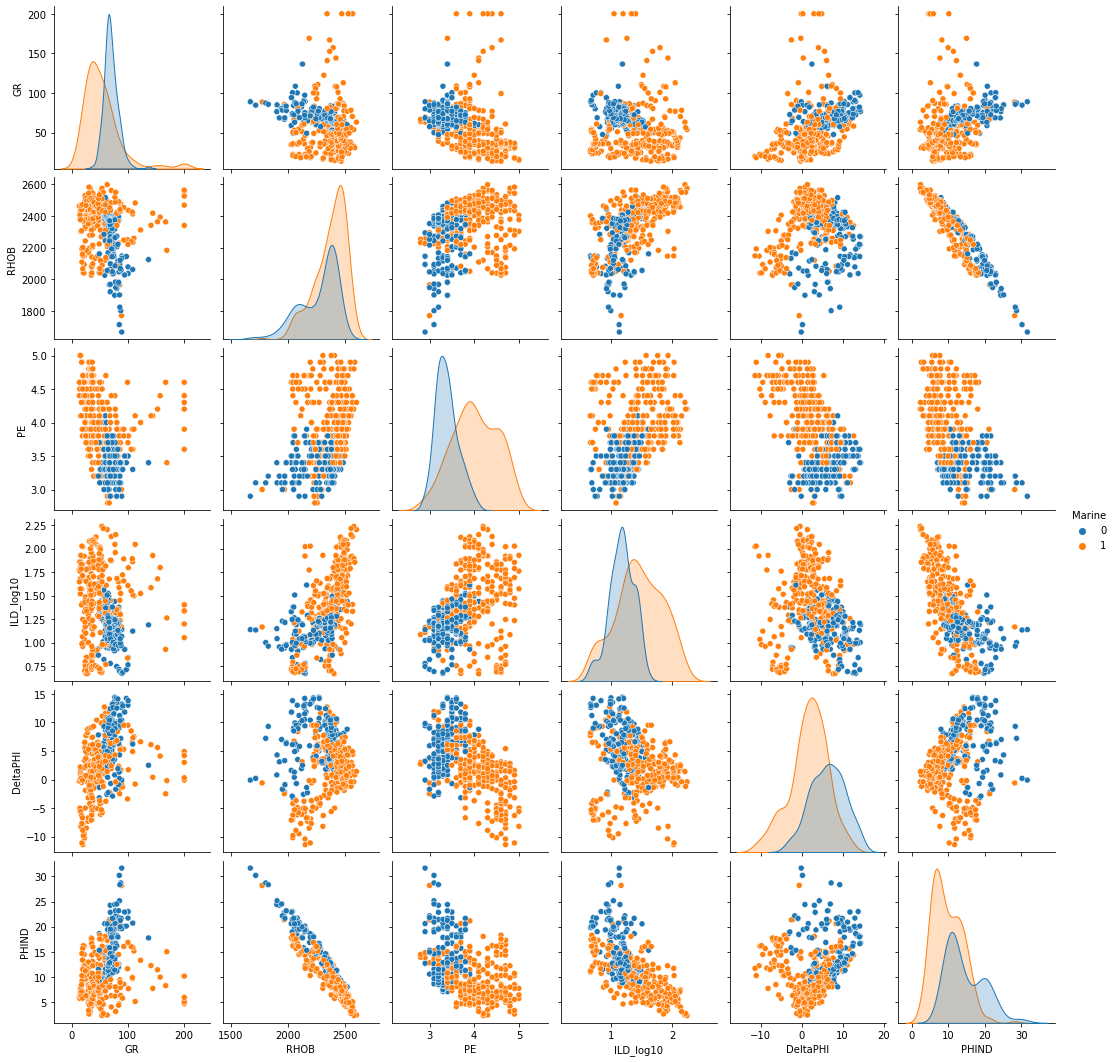

In [4]:
import seaborn as sns

features = ['GR', 'RHOB', 'PE', 'ILD_log10', 'DeltaPHI','PHIND'] #, 'Marine']
chosen_well = df['Well Name'].unique()[5]
sns.pairplot(df.loc[df['Well Name'] == chosen_well], vars=features, hue='Marine')

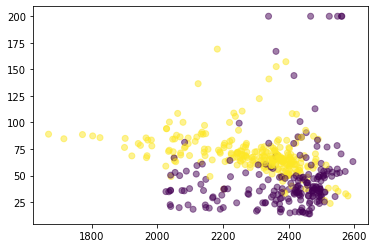

In [5]:
import matplotlib.pyplot as plt

plt.scatter(*X.T, c=y=='siliciclastic', alpha=0.5)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()  # we are going to use these later

In [6]:
def is_silica(y):
    return y == 'siliciclastic'

## A linear model: SVM

In [7]:
from sklearn.svm import SVC

svc = SVC(kernel='linear')

svc.fit(X, y)

y_pred = svc.predict(X)

In [ ]:
plt.figure(figsize=(12, 9))
plt.scatter(*X.T, c=is_silica(y), s=80, cmap='bwr')
plt.scatter(*X.T, c=is_silica(y_pred), s=20)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y, y_pred)

## Plot the decision boundary

We can visualize the decision boundary, and the class 'regions' using a small function in `mlutils.py`:

In [ ]:
import numpy as np
from mlutils import decision_regions

extent = [round(xlims[0]), round(xlims[1]), round(ylims[0]), round(ylims[1])]
y_pred, y_all = decision_regions(svc, X, y, extent, step=(5, 1))
ma = np.percentile(y_all, 90)
    
plt.figure(figsize=(12, 9))
plt.imshow(y_all, extent=extent, origin='lower', aspect='auto', vmin=-ma, vmax=ma, cmap='RdBu')
plt.colorbar(shrink=0.5)

In [ ]:
plt.figure(figsize=(12, 9))
plt.imshow(y_all >= 0.0, extent=extent, origin='lower', aspect='auto', alpha=0.5)
plt.scatter(*X.T, c=is_silica(y), s=80, cmap='bwr')
plt.scatter(*X.T, c=is_silica(y_pred), s=20)
plt.show()

## A non-linear SVM model

If we employ the **kernel trick** we can fit a nonlinear model. Scikit-learn's `SVC` actually uses this by default:

In [ ]:
from sklearn.svm import SVC

svc = SVC()  # Default is kernel='rbf'

svc.fit(X, y)

y_pred = svc.predict(X)

plt.scatter(*X.T, c=is_silica(y), s=80, cmap='bwr')
plt.scatter(*X.T, c=is_silica(y_pred))
accuracy_score(y, y_pred)

In [ ]:
y_pred, y_all = decision_regions(svc, X, y, extent, step=2)
    
plt.figure(figsize=(15, 9))
plt.imshow(y_all >= 0.0, extent=extent, origin='lower', aspect='auto', alpha=0.5)
plt.scatter(*X.T, c=is_silica(y), s=80, cmap='bwr')
plt.scatter(*X.T, c=is_silica(y_pred))
plt.show()

## Validation

We should not train the model, then check its accuracy only on that dataset. It's cheating.

Let's hold out some validation data, or 'blind' data.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=99)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

Now let's train a model *on only the training data* and validate it properly.

In [ ]:
svc = SVC().fit(X_train, y_train)

y_pred = svc.predict(X_val)

accuracy_score(y_val, y_pred)

# Standardize the data
Note that it's a good idea to train SVMs on the Z-scores of your data, i.e. zero mean, StdDev = 1. This ensures that the different scales of the features is not causing a problem. (They are about the same scale in our dataset so the effect is small.)

In [ ]:
plt.scatter(*X_train.T)
plt.axis('equal')

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
svc = SVC(probability=True)

svc.fit(X_train, y_train)

svc.score(X_val, y_val)

## Draw the decision boundary

In [1]:
def standardize_extents(scaler, xlims, ylims):
    """
    Provides scaled x and y limits for making grids.
    scaler: the StandardScaler from X_train
    xlims: the xmin and xmax of the unscaled axis (list or tuple)
    ylims: the yimin and ymax of the unscaled axis (list or tuple)
    """
    extent = [round(xlims[0]), round(xlims[1]), round(ylims[0]), round(ylims[1])]
    stnd_extent = np.array(extent).reshape(2,2).T
    stnd_extent = scaler.transform(stnd_extent)
    stnd_extent = [round(val) for val in stnd_extent.T.ravel()]
    return stnd_extent

In [ ]:
y_pred, y_all = decision_regions(svc, X_val, y_val, stnd_extent, step=0.02)
    
plt.figure(figsize=(15, 9))
plt.imshow(y_all >= 0.0, extent=stnd_extent, origin='lower', aspect='auto', alpha=0.5)
plt.scatter(*X_train.T, c=is_silica(y_train), marker='+', cmap='bwr')
plt.scatter(*X_val.T, c=is_silica(y_val), s=80, cmap='bwr')
plt.scatter(*X_val.T, c=is_silica(y_pred))
plt.show()

## Using this model

If we wanted to use our model now, we should now retrain it on all the data; presumably, this is at least as good as the one trained on the training set, we just don't have a way to check it now.

In [ ]:
scaler = StandardScaler().fit(X)
X_ = scaler.transform(X)
svc = SVC().fit(X_, y)

# Multi-class classification with more than two features

Let's return to the original DataFrame to try lithology prediction.

## Make `X` and `y`

### EXERCISE

**Make the `X` and `y` arrays we'll use for training.** `X` is going to be the columns `'GR','RHOB','PE','ILD_log10'` and `y` will be the `'Lithology'` column. Cast the data to NumPy arrays. <a title="Use ordinary dict-style indexing to get the columns out of the DataFrame. Use the values attribute of the columns to get the equivalent NumPy array."><b>Hover for HINT</b></a>

In [ ]:
# YOUR CODE HERE


In [ ]:
features = ['GR','RHOB','PE','ILD_log10']

# You *can* leave these as Pandas objects, but I prefer NumPy arrays.
X = df[features].values
y = df['Lithology'].values

In [ ]:
N, M = X.shape
assert N >= 3000
assert M == 4
assert y.size == N

## Split the data

We must split the data into a training set, a validation set, and a test set. **This is a key step in the process.**

Scikit-learn has a function called `train_test_split`:

```python
from sklearn.model_selection import train_test_split

X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4, random_state=42)
```

but we are't going to use it because it violates the IID assumption.

How do we feel about this? We've drawn all our records randomly from our data.

### The IID assumption

Our data records are not strictly independent and identically distributed. So splitting like this is not a great idea for these data. We should split by well instead.

[No-one is immune to this kind of error!](https://twitter.com/andrewyng/status/931026446717296640)

Note: the `train_test_split` function splits your `X` and `y` into two groups. What we need is three groups: train, validation, and test. The training set is for *building* the model(s), the validation set is for scoring the model(s) and selecting hyperparameters (sometimes also called the **dev** set), and the *test* set is used one to assess the likely real-world performance of the trained model.

Note that you should only predict on the **test** set once, at the end of model selection and tuning.

If the I.I.D assumption was valid then we could get our `train`, `val`, and `test` sets using the `train_test_split` function twice like so:
```python
from sklearn.model_selection import train_test_split

X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)
```
But since I.I.D does not hold we can pull our samples on a well by well basis. In doing so we must make sure that we have similar proportions of lithologies in each of the three sets.

## MultiIndex

What if you have a multi-index?

In [ ]:
dg = df.copy()

dg = dg.set_index(['Well Name', 'Depth'])

dg.head()

In [ ]:
pd.crosstab(dg['Lithology'], dg.index.get_level_values('Well Name'))

### EXERCISE

What is the distribution of lithologies across the wells? <a title="Check out pd.crosstab"><b>Hover for HINT</b></a>

In [ ]:
# YOUR CODE HERE


In [ ]:
pd.crosstab(df['Lithology'], df['Well Name'])

In [ ]:
ct = pd.crosstab(df['Lithology'], df['Well Name'])

# Let's order this crosstab so that the validation and test wells are on the far right.
# Also, let's set the order of the lithologies in the table.
train_wells = ['NEWBY', 'CROSS H CATTLE', 'LUKE G U', 'NOLAN', 'SHRIMPLIN']
val_wells = ['CHURCHMAN BIBLE', 'SHANKLE']

lith_order = ['sandstone', 'siltstone', 'mudstone', 'wackestone', 'limestone', 'dolomite']

# Reindex the columns and the row.
ct = ct[train_wells + val_wells].reindex(lith_order)

# Normalize to percentages by row.
ct_norm = 100 * ct.div(ct.sum(axis=1), axis=0)

# Apply the bar style.
# ct_norm.style.bar(color=['#d65f5f', '#5fba7d'], vmax=0.5)

# Get really fancy: apply style from normalized ct to the un-normalized one.
def make_bar_style(x):
    c = f"#5fba7d {x}%" if x > 10 else f"#ca3f3f {x}%"  # Green if > 10% else red.
    return f"background: linear-gradient(270deg,{c}, transparent {x}%); width: 10em"    

ct.style.apply(lambda x: ct_norm.applymap(make_bar_style), axis=None)

In [ ]:
from matplotlib.colors import ListedColormap

color_codes = {'dolomite': '#C186C1',
              'limestone': '#2E86C1',
              'wackestone': '#728393',
              'mudstone': '#C1C1C1',
              'siltstone': '#F3E8BF',
              'sandstone': '#F4D03F'}

cmap_facies = ListedColormap(color_codes.values(), 'indexed')
ax = ct.T.plot(kind='bar', stacked=True, rot=0, figsize=(10,6), cmap=cmap_facies)
_ = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

### Let's split!

In [ ]:
df['Well Name'].unique()

In [ ]:
train_wells = ['NEWBY', 'CROSS H CATTLE', 'LUKE G U', 'NOLAN', 'SHRIMPLIN']

X_train = df.loc[df['Well Name'].isin(train_wells), features].values
y_train = df.loc[df['Well Name'].isin(train_wells), 'Lithology'].values

# And we might need this later...
wells_train = df.loc[df['Well Name'].isin(train_wells), 'Well Name'].values

In [ ]:
X_train.shape, y_train.shape

In [ ]:
val_wells = ['CHURCHMAN BIBLE', 'SHANKLE']

X_ = df.loc[df['Well Name'].isin(val_wells), features].values
y_ = df.loc[df['Well Name'].isin(val_wells), 'Lithology'].values

In [ ]:
X_.shape, y_.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)

Another option is k-fold cross-validation, or LOGO (leave one group out) cross-validation. But if you have enough training data, it's better to stick to holdout sets.

## Sanity check the distributions

Let's visualize the distributions over the features, for each of the datasets. We'd like the distributions to match, i.e. training matches val and test.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=4, figsize=(14,3))

for ax, feature, *datasets in zip(axs, features, X_train.T, X_val.T, X_test.T):
    for dataset in datasets:
        sns.kdeplot(dataset, ax=ax)
    ax.set_ylabel(None)
    ax.set_title(feature)

## Standardizing the data

Some methods don't care about the scale of the features. For example, decision trees and random forests treat each feature independently.

However, most methods &mdash; for example those relying on distance (e.g. KNN), or on linear combinations (e.g. linear regression), or on squeezing functions (e.g. neural nets) &mdash; require the data to be normalized or standardized:

- **Normalization**: scaling to a range of [0, 1] or [-1, +1] for example. As a rule of thumb, you might do this for uniformly distributed data.
- **Standardization**: scaling to a zero mean and unit variance (also known as Z-score). Do this for normally (Gaussian) distributed data.

It's likely a good idea to scale it no matter which method you try.

`scikit-learn` has lots of scalers. The `StandardScaler` removes the mean and scales the data to unit variance.

Let's take a quick look at the data before scaling:

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(X_train[:,0], X_train[:,1])
plt.show()

Notice that interpreting this as a Euclidean space — which is how a lot of machine learning models are going to look at it — seems to distort the data, purely because of the (potentially arbitrary, as here) difference in scales across the features. 

In [ ]:
x0, x1 = X[20, :2], X[2490, :2]

plt.scatter(X_train[:,0], X_train[:,1])
plt.scatter(*x0.T, c='r')
plt.scatter(*x1.T, c='r')
# plt.axis('equal')  # <-- Now uncomment this line to see how Euclid sees it!
plt.show()

We fit a scaler to the training data, then transform all the datasets, with a pattern that will become very familiar:

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

Note that it is possible to fit and transform some models in one step:

    X = scaler.fit_transform(X)
    
You could even instantiate the model instance in the same statement, but this has the major disadvantage of not getting access to the model later.

Now let's plot the data using equal axes:

In [ ]:
s0 = scaler.transform(X)[20, :2]
s1 = scaler.transform(X)[2490, :2]

plt.scatter(X_train[:,0], X_train[:,1])
plt.scatter(*s0.T, c='r')
plt.scatter(*s1.T, c='r')
plt.axis('equal')
plt.show()

This is better.

Let's scale the validation data too:

In [ ]:
X_val = scaler.transform(X_val)

# We won't transform X_test for now.

We can also reconfirm that our training and validation sets have roughly the same distributions:

In [ ]:
plt.scatter(X_train[:,0], X_train[:,1])
plt.scatter(X_val[:,0], X_val[:,1])

Since any future application of the model will need this scaler, you may need to share it with others who want to apply the model. There are two options for this:

- Share the scaler as a separate 'model'.
- Make an `sklearn` pipeline containing both the scaler and the classifier.

We'll do both of these eventually. For now, we'll just keep this scaler in memory and move on.

**NOTE**

Data normalization doesn't magically fix problems with the data. If you're lumping a bunch of well data together and the GR, say, is calibrated differently in each well, or the RHOB units vary, then the scaled data will also have this problem. So you still need to QC your data to ensure it's internally consistent.

### Should you scale the target?

There is usually no advantage to scaling the target, and it does make model evaluation a bit more fiddly, so we generally don't do it.

The exception is for some neural network approaches. Very large magnitudes may result in 'exploding gradients', which in turn may result in 'saturation' (for some activation functions), or in very large updates to the parameters. Either way, the network will struggle to learn. So in these cases, we will sometimes scale a regression target for a neural network.

---

## A simple model: _k_-NN

In [ ]:
import sklearn

print(sklearn.__version__)

# Make sure we can see all of the model details.
sklearn.set_config(print_changed_only=False)

A fairly naive, **non-parametric** method for classifying data is the _k-nearest neighbours_ algorithm. 'Non-parametric' means that, strictly speaking, it's not quite machine learning: no parameters are being learned during training. The algorithm simply remembers all the data and uses it to do spatial queries for new data points.

The label of the object in question is determined by the neighbouring data points in the feature space used. Its most important parameter, *k*, called `n_neighbors` in the `sklearn` library, is the number of neighbours you include to make a prediction.

In [ ]:
from mlutils import plot_knn

plot_knn()

Now we're ready to do some machine learning. First we import, then instantiate, the classifier:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()

### `fit` (train)

The next block is all you need to train a classifier model!

In [ ]:
clf.fit(X_train, y_train)

### `predict`

In [ ]:
y_pred = clf.predict(X_val)

In [ ]:
y_pred == y_val

# Then: (y_pred == y_val) / y_pred.size

In [ ]:
for pair in zip(y_pred, y_val):
    print(pair)

In [ ]:
plt.figure(figsize=(15, 2))
plt.plot(y_val[:100], 'o-')
plt.plot(y_pred[:100], 'o-')
plt.show()

Another approach might involve plotting, and often we'd like integers anyway. 

We could use the `LabelEncoder` in sklearn, but I want to control the order, so let's do this:

In [ ]:
import numpy as np

def label_encode(array, classes):
    return np.array(list(map(list(classes).index, array)))

classes = {
    'sandstone': '#F4D03F',
    'siltstone': '#F3E8BF' ,
    'mudstone': '#C1C1C1',
    'wackestone': '#728393',
    'limestone': '#2E86C1',
    'dolomite': '#C186C1',
}

print(label_encode(classes, classes.keys()))

y_val_int = label_encode(y_val, classes.keys())
y_pred_int = label_encode(y_pred, classes.keys())

In [ ]:
plt.imshow(y_val_int.reshape(-1, 1), aspect=0.01)

In [ ]:
from matplotlib.colors import ListedColormap

fig, axs = plt.subplots(ncols=3, figsize=(5, 10), sharey=True)

cmap_facies = ListedColormap(classes.values(), 'indexed')

ax = axs[0]
im = ax.imshow(y_val_int[:100].reshape(-1, 1), aspect='auto', cmap=cmap_facies, vmin=-0.5, vmax=5.5)
ax.set_title('Actual')

ax = axs[1]
im = ax.imshow(y_pred_int[:100].reshape(-1, 1), aspect='auto', cmap=cmap_facies, vmin=-0.5, vmax=5.5)
ax.set_title('Predicted')

ax = axs[2]
ax.axis('off')
cbar = fig.colorbar(im, ticks=[0, 1, 2, 3, 4, 5])
cbar.ax.set_yticklabels(classes.keys())

plt.show()

There may not be any no dolomite in this *part* of the prediction!

In [ ]:
np.unique(y_pred)

...or any of it! (Your mileage may vary: our datasets and random splits may differ here.)

### How did we do?

Looking at the results is great, but we need to get quantitative if we want to make sure that the model we trained is _good_ and produces reasonable results. 

Let's make sure we do well on the **training** data:

In [ ]:
score = clf.score(X_train, y_train)
print(f"The training accuracy is {score*100:.1f}%")

The most basic *fair* test is to look at how many good predictions we would make if we predict on our **validation** data.

In [ ]:
score = clf.score(X_val, y_val)
print(f"The validation accuracy is {score*100:.1f}%")

This is the same as explicitly calling `sklearn.metrics.accuracy_score()` on the validation labels and the prediction from the validation data.

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_val, y_pred))

## Accuracy is (usually) not enough

The _accuracy_ is just one of the _metrics_ we can use to check the quality of the predictions. There are a large number of different metrics and depending on your data and problem you may need to find the one that adjusts better to your needs.

In a binary classification with balanced classes, the accuracy score is useful. But... in general accuracy can be misleading, especially in datasets with unbalanced classes. A more robust metric is the `F1` metric. It combines the `precision` score and `recall` for each class:

$$ \mathrm{F1} = \frac{2}{\frac{1}{\mathrm{precision}}+ \frac{1}{\mathrm{recall}}} $$

Scikit-learn gives a nice summary of these three metrics using `classification_report`.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_val, clf.predict(X_val), digits=3, ))

#### What on earth is macro average?

From [this nice answer](https://datascience.stackexchange.com/a/24051/70391) on SO:

>  A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average [`sklearn` calls it the weighted average] will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average [weighted average] is preferable if you suspect there might be class imbalance.

Since we almost always have imbalanced classes, we should usually prefer the weighted average.

## Dealing with class imbalance

"Class imbalance" means that we have more of some labels than others. This does lead to problems in both training and evaluation.

- Collect more data, if it's an option.
- Choose correct evaluation metrics (some attempt to handle imbalance, eg F1 vs accuracy).
- Choose models that handle imbalance well, e.g. tree-based models. (Some implementations, like XGBoost, try to implicitly handle imbalance.)
- When splitting into holdout or cross-validation datasets, use _stratified_ variants. Note that this is the default behaviour in Scikit-Learn's cross-validation functions, but _not_ in `train_test_split()`.
- If the problem is an over-abundant class, split that class into groups, and mix with the rare class (which you repeat in each group).
- If the problem is an over-abundant class, under-sample the abundant class(es) -- but this means losing the learning effect from those samples.
- If the problem is an over-abundant class, cluster the abundant class into _r_ clusters (where _r_ is the number of instances in the rare class). In other words, you're sort of undersampling without losing the information.
- If the problem is an _under_-abundant class, over-sample that rare class, e.g. by repeating or fuzzing (adding some random noise in each dimension).
- Simulate synthetic samples for the rare class (e.g. with SMOTE).
- Use a custom cost function, or a cost matrix, that penalizes errors on the rare class(es).

I found this library, which could be useful if you're considering over- or under-sampling as a strategy: https://github.com/scikit-learn-contrib/imbalanced-learn

## Confusion matrix

The [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is another option: which classes are being confused with which?  Scikit-learn has a function for that!

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_pred)

But as you can see, it's not very clear... What does each row/column represent? There's another function that's a bit more informative:

In [ ]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(clf, X_val, y_val, labels=list(classes.keys()), cmap=plt.cm.Greens, ax=ax)
plt.show()

I like to normalize the values across the rows with `normalize='true'`, but then you only get proportions for the labels. To maintain the support numbers as above:

In [ ]:
labels = list(classes.keys())
cm = confusion_matrix(y_val, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(10, 8))
cmp = plot_confusion_matrix(clf, X_val, y_val, labels=labels, normalize='true', cmap=plt.cm.Greens, ax=ax)
for n, p in zip(cm.ravel(), cmp.text_.ravel()):
    p.set_text(f'{n}\n[{p.get_text()}]')
plt.show()

### Precision-recall, sensitivity-specificity, etc.

**Accuracy** is simply the number of correct predictions divided by the total number of predictions. The number and types of error don't come into it. There's one number for the entire prediction. And it omits a big part of the story.

There are various ways to capture the kinds of errors the classifier makes. Confusingly, they all have synonyms too (shown here)...

- **Precision, or positive predictive value**: of the instances predicted as class Ⓐ, what proportion were correct?
- **Recall, sensitivity, hit rate, or true positive rate**: what proportion of all Ⓐ instances were correctly predicted as Ⓐ?
- **Specificity, selectivity, or true negative rate ( = 1 - false positive rate)**: what proportion of all non-Ⓐ instances were correctly predicted as non-Ⓐ?

We tend to consider either precision and recall, or sensitivity (the same as recall) and specificity. There's a trade-off between the two: better recall involves giving up some precision and vice-versa.

The ROC curve tries to capture this trade-off. Look for [the binary classification notebook](Binary_classification.ipynb).

## Subtlety in the score

Let's look at two types of error. 

Both of these are errors in the eyes of the ML algorithm, but not necessarily in the eyes of the geologist.

First: predicting 8 (maybe coarse sand) instead of 7 (fine sand) should not be as bad as predicting 2 (say, basalt) instead of 7. How could we fix this?

In [ ]:
from IPython.display import Image

Image("../images/classification_errors.png")

## The baseline: a dummy classifier

The dummy classifier tries to answer the question, "How well can I do with zero intelligence?". In other words, given the relative proportions of facies, what would you expect from random weighted guesses?

In [ ]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred))

In essence, if I can't beat this, then my model is definitely not useful.

Another measure of 'useful' is whether the classifier can beat a human (but don't forget that these labels were generated by a human!).

## Improving the performance

Depending on you requirements, this results might be good enough to deploy this model and use it in production but it is usually not the best model you can get. Each method has a set of controls or arguments, known as _hyperparameters_, that can be tweaked to tune the training.

Note that we don't call these settings 'parameters' because that word is reserved for the learnable parameters, weights, or coefficients in the model (e.g. $\mathbf{w}$ and $b$ in $\hat{y} = \mathbf{w}\mathbf{x} + b$).

For the `KNeighborsClassifier` there are a few of these hyperparameters:

In [ ]:
KNeighborsClassifier()

For this particular method, the most important hyperparameter to adjust is `n_neighbors` (it's the `k` in the `KNeighborsClassifier`). Unfortunately, there's no rule that tells you what's the optimal value of `k`. To overcome this we can train many models with different values of `k` and compare the results of classifications applied to the _Validation_ data.

In [ ]:
import numpy as np

k = np.arange(1, 60, 2)  # No need to test all values.

Loop over each value in `k` and store the F1 score for each attempt:

In [ ]:
from sklearn.metrics import f1_score

vals, trns = [], []

for ki in k:
    clf = KNeighborsClassifier(n_neighbors=ki)
    clf.fit(X_train, y_train)
    
    y_ptrn = clf.predict(X_train)
    trns.append(f1_score(y_train, y_ptrn, average='weighted'))

    y_pred = clf.predict(X_val)
    vals.append(f1_score(y_val, y_pred, average='weighted'))

What value of `k` gives us the best result?

In [ ]:
plt.plot(k, trns, lw=3.0, label="Training F1 score")
plt.plot(k, vals, lw=3.0, label="Validation F1 score")
_ = plt.xlabel('n_neighbors')
_ = plt.ylabel('clf.score')
_ = plt.legend()

### Exercise

- Figure out `k_best`, the value of `k` corresponding to the best score in `vals`. <b><span title="You will find np.argmax() useful. It gives the position of the maximum value in an array. Try it on array([2,4,6,10,6,4,2]).">Hover for hint.</span></b>
- Create a new `KNeighborsClassifier` classifier where you specify the optimal number of neighbours.
- Write a new classification report for the new classifier.

In [ ]:
# YOUR CODE HERE



In [ ]:
k_best = k[np.argmax(vals)]

print(f"k_best = {k_best}\n")

clf = KNeighborsClassifier(k_best)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred, digits=3))

----

## Support vector machine

The support vector machine is one of the classic linear classifiers. A linear SVM is a **parametric** model, meaning that it learns a relatively small number of model parameters during training. [See this link for more on this jargon.](https://sebastianraschka.com/faq/docs/parametric_vs_nonparametric.html)

SVMs &mdash; linear and kernel-based &mdash; do well in high-dimensional data, but not sparse data. They also need all the features to be at the same scale, so they work well for things like pixel intensities.

### Exercise

Implement a support vector classifier and checks its effectiveness on the validation data, e.g. by printing the classification report.

In [ ]:
from sklearn.svm import SVC

# YOUR CODE HERE


In [ ]:
from sklearn.svm import SVC

clf = SVC(probability=True)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred, digits=3))

Many, but not all, models provide probabilistic classifications. When you call `predict()`, you're getting the `argmax` of this array†.

---

† Sort of... the probabilities do not necessarily exactly match the predictions made by the SVM, which depend on the distance to the decision hypersurface in a high-dimenional space. The process that estimates probability, Platt scaling, is not totally predictable; [see the documentation.](https://scikit-learn.org/stable/modules/svm.html#scores-and-probabilities)

In [ ]:
np.set_printoptions(precision=4, suppress=True)

clf.predict_proba(X_val)

Note that by default, the SVM will use regularization (unlike the usual alpha, the C hyperparameter is **inversely** proportional to the amount of regularization, so use low C for smoother models), and kernel transformations (fitting non-linearly separable data).

Let's see how the training and validation scores vary with C:

In [ ]:
Cs = [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10, 30]
trains, vals = [], []

for C in Cs:
    clf = SVC(C=C).fit(X_train, y_train)
    trains.append(clf.score(X_train, y_train))
    vals.append(clf.score(X_val, y_val))

plt.plot(Cs, vals, 'o-', label="Val. score")
plt.plot(Cs, trains, 'o-', label="Train. score")
plt.xlabel('C (proportional to complexity)')
plt.xscale('log')
_ = plt.legend()

Looks like the range 0.3-ish is where we want to look.

In [ ]:
clf = SVC(C=0.5)  # Pick a good compromise.

clf.fit(X_train, y_train)

print(classification_report(y_val, clf.predict(X_val), digits=3))

----
## Decision tree

Decision trees are another non-parametric model type (like KNN).

They have the advantage of being more explainable than a lot of other model types. They tend to do quite well with little tuning, however they are prone to overfitting.

### Exercise

Implement a decision tree.

In [ ]:
# YOUR CODE HERE



In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=4)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred, digits=3))

Being able to see feature importances is a nice feature of decision trees:

In [ ]:
clf.feature_importances_

In [ ]:
features

...and so is being able to see the tree.

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))

_ = plot_tree(clf,
              filled=True,
              feature_names=features,
              class_names=clf.classes_,
              fontsize=8,
             )

## Random forests

Decision trees are prone to overtraining. An ensemble of decision trees can help avoid this... and makes for a highly effective classifier.

### Exercise

Implement a Random Forest.

In [ ]:
# YOUR CODE HERE



In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=4).fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred, digits=3))

---

## Choosing the right estimator

Often the hardest part of solving a machine learning problem can be finding the right estimator for the job.

This is a good place to start ([here](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) is a clickable version):

<img src="https://scikit-learn.org/stable/_static/ml_map.png"></img>

---

Different estimators are better suited for different types of data and different problems. For a classifier comparison (below) check the source code [here](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png"></img>

### [Check out this paper with a comparison of many classifiers](https://arxiv.org/abs/1708.05070)

### Exercise

- Can you beat our current high score by twiddling hyperparameters on one of these models?
- Or, try other methods available in the scikit-learn library. See the list [here](http://scikit-learn.org/stable/supervised_learning.html). For example, get a sneak peek at neural nets with the MLP.

In [ ]:
# YOUR CODE HERE


In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=[24, 12],
                    learning_rate='constant',
                    alpha=0.001,
                    max_iter=5000,
                    solver='adam',
                    random_state=42,
                   )

clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier

clf = GradientBoostingClassifier(random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(classification_report(y_val, y_pred))

----

## Hyperparameter tuning

Many of the models can be improved (or worsened) by changing the parameters that internally make the method work. It's always a good idea to check the documentation of each model (e.g. `RandomForestClassifier` [docs](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). This process is usually called _hyperparameter tuning_.

Scikit-learn offers a simple way to test different parameters for each model through a function called `GridSearchCV`.

The default behviour is to split the training data randomly into _k_ 'folds' (e.g. with `cv=6` in line 9 below). But our records are not IID (specifically, not independent) so we can't do this. We'll split across the wells instead by defining a 'LOGO' splitter:

In [ ]:
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut

parameters = {'min_samples_leaf': np.arange(3, 19),
              'max_depth': np.arange(2, 13)}

logo = LeaveOneGroupOut().split(X_train, y_train, groups=wells_train)

rfc = RandomForestClassifier(random_state=42)
clf = GridSearchCV(rfc, parameters, cv=logo, n_jobs=6, verbose=3)
clf.fit(X_train, y_train)

Let's see how we do on each well as we omit it from the training in turn:

In [ ]:
for i, well in enumerate(np.unique(wells_train)):
    scores = clf.cv_results_[f'split{i}_test_score']
    print(f"{well:>16s} ... {np.mean(scores):.4f}")

How does the parameter space look with respect to the score of the classifier?

In [ ]:
scores = clf.cv_results_['mean_test_score']

fig, ax = plt.subplots(figsize=(9, 7.5))
im = ax.imshow(scores.reshape((11, 16)),
               origin='lower',
               extent=[2.5, 18.5, 1.5, 12.5],
               interpolation='none',
               aspect=1,
               cmap='viridis'
              )
ax.set_ylabel('max_depth')
ax.set_xlabel('min_samples_leaf')
cb = plt.colorbar(im, shrink=0.6)

`clf` can now tell us the best parameters to use with our `RandomForestClassifier`

In [ ]:
clf.best_params_

In [ ]:
clf.best_estimator_

The nice thing about `scikit-learn`'s methods is that they're all consistent and behave in the same way. Notice how`GridSearchCV` was `.fit()`. That means that we can use it to `.predict()` and it will automatically use the best set of parameters!

In [ ]:
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, digits=3))

In [ ]:
clf.score(X_train, y_train), clf.score(X_val, y_val)

## Model application, and pipelines

Don't forget that you'll also need the scaler that goes with the model. The best idea is probably to make a pipeline which contains both the scaler and the classifier; then you only have one model to share.

Making pipelines is easy. We just have to provide (from the docs) **a list of (name, transform) tuples (implementing fit/transform) that are chained, in the order in which they are chained, with the last object an estimator.**

In [ ]:
from sklearn.pipeline import Pipeline

model = Pipeline(steps=[('scaler', scaler),
                        ('classifier', clf),
                       ])

This is 'just' an `sklearn` model.

Now might be a good time to check our **test** set — the one we reserved at the start. How might our model do on this dataset?

In [ ]:
y_pred = model.predict(X_test)  # X_test was unscaled.

f1_score(y_test, y_pred, average='weighted')

We get a similar result to the validation set. That's good.

The pipeline is convenient whenever we have multiple steps in the prediction workflow, because it ensures we'll be consistent and makes it easier to save the model (below).

## Training the final model

Now that we have selected the model we want to use, we should retrain it on all of the data.

NB We could omit the scaling step for a random forest. But it doesn't do any harm...

In [ ]:
scaler = StandardScaler().fit(X)

rf = RandomForestClassifier(random_state=42, **clf.best_params_).fit(X, y)

model = Pipeline(steps=[('scaler', scaler),
                        ('classifier', rf),
                       ])

## Model persistence

Often, we'd like to save the trained model, to go and apply it in some other application, or to share with someone else. The easiest way to save most models is as a Python 'pickle' object:

In [ ]:
import joblib

joblib.dump(model, 'facies_pipeline.pkl')

## Model application

How do you load and use a saved model?

In [ ]:
model = joblib.load('facies_pipeline.pkl')

In [ ]:
model.named_steps

Now you can load some data:

    df = pd.read_csv('..some_new_data_you_have_collected.csv')
  
Then extract the relevant features and cast it as a 2D array:

    X_new = df[['GR','RHOB','PE','ILD_log10']].values

Now pass the matrix `X_new` into the classifier's predict method:

    y_pred = model.predict(X_new)

And you're done!

<hr />

<p style="color:gray">©2020 Agile Geoscience. Licensed CC-BY.</p>